## Build environment


In [1]:
from mss import mss
import cv2
from pynput.keyboard import Key, Controller as KeyBoardController
from pynput.mouse import Button, Controller as MouseController
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

In [2]:
class WebGame(Env):
    def __init__(self):
        super().__init__()

        # Input setup
        self.keyboard = KeyBoardController()
        self.mouse = MouseController()

        # Spaces setup
        self.observation_space = Box(
            low=0, high=255, shape=(1, 83, 100), dtype=np.uint8
        )
        self.action_space = Discrete(3)

        # Define extraction parameters for the game
        self.cap = mss()
        self.game_location = {"top": 300, "left": 0, "width": 600, "height": 500}
        self.done_location = {"top": 460, "left": 620, "width": 660, "height": 60}

    # An action that is passed into the game
    def step(self, action):
        # Action key - 0 = Space, 1 = Duck, 2 = No action
        action_map = {
            0: Key.space,
            1: Key.down,
            2: "no_op",
        }

        if action != 2:
            self.keyboard.press(action_map[action])

        done, _ = self.get_done()
        new_observation = self.get_observation()
        # We get a reward every frame we're alive
        reward = 1
        # Info dictionary
        info = {}

        return new_observation, reward, done, info

    # Visualize the game
    def render(self):
        # Flakey, I don't know really what to do with the quit
        cv2.imshow("Game", np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord("q"):
            self.close()

    # Restart the game
    def reset(self):
        time.sleep(3)
        self.mouse.position = (600, 600)
        self.mouse.click(Button.left, 1)
        return self.get_observation()

    # Closes down the observation
    def close(self):
        cv2.destroyAllWindows()

    # Get part of the observation of the game
    def get_observation(self):
        # Get screen capute of the game
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3]
        # Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (100, 83))
        # Add channels first
        channel = np.reshape(resized, (1, 83, 100))

        return channel

    # Get the done text
    def get_done(self):
        # Get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]
        # Valid done text
        done_strings = ["GAME", "GAHE", "GCAR", "GARN", "GCA "]

        # Apply OCR
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]

        if res in done_strings:
            done = True

        return done, done_cap

In [3]:
env = WebGame()

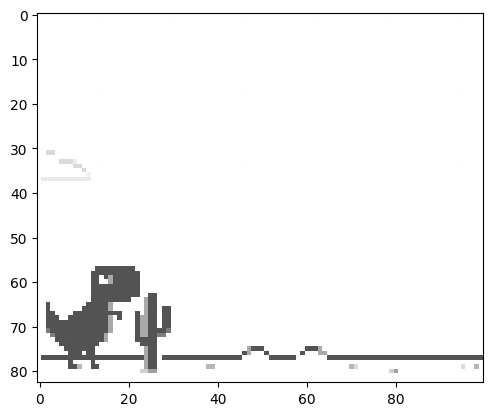

In [4]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

Detected game over:  True


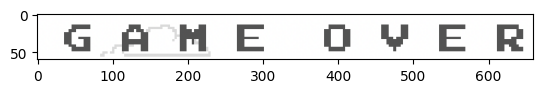

In [5]:
done, done_cap = env.get_done()
print("Detected game over: ", done)
plt.imshow(done_cap)

In [6]:
# WIP
# for episode in range(10):
#     obs = env.reset()
#     done = False
#     total_reward = 0

#     while not done:
#         obs, reward, done, info = env.step(env.action_space.sample())
#         print(done)
#         total_reward += reward
#         print(f"Total reward for episode {episode} is {total_reward}")

    